### Backtesting with GAN

기존의 OU-process를 따르던 확률 과정을 GAN모형으로 대체한다면 어떻게 변할까?

In [1]:
import pandas as pd
import numpy as np

from scipy.optimize import fmin
from scipy.special import lambertw
from scipy.stats import kurtosis, norm

import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm
import yfinance as yf
import random

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
random.seed(42)
torch.manual_seed(42)

In [3]:
x = torch.ones(1, device = device)
print(x)

sp500 = yf.download('AAPL','2015-01-01','2024-03-01')

tensor([1.], device='mps:0')
[*********************100%%**********************]  1 of 1 completed


In [4]:
sp500log = np.log(sp500["Close"] / sp500["Close"].shift(1)).dropna()

<Axes: xlabel='Date'>

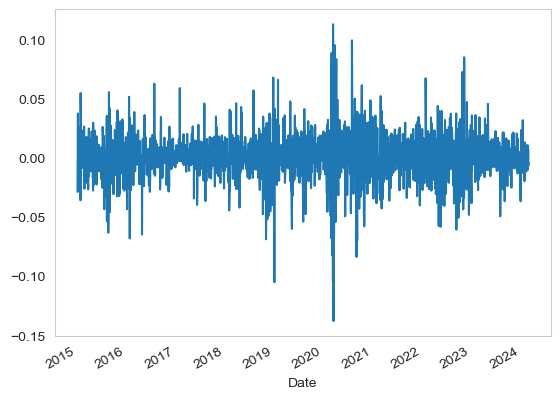

In [6]:
sp500log.plot(grid = False)

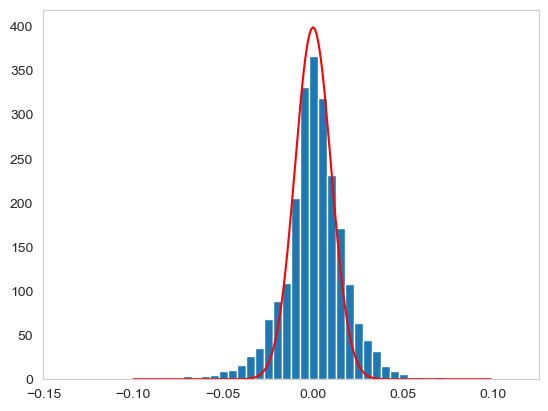

In [10]:
plt.hist(sp500log, bins = 50)
x_axis = np.arange(-0.1, 0.1, 0.001)
plt.plot(x_axis, norm.pdf(x_axis, 0, 0.01) * 10, color= 'r')
plt.grid(False)
plt.show()

In [11]:
def delta_init(z):
    k = kurtosis(z, fisher=False, bias=False)
    if k < 166. / 62.:
        return 0.01
    return np.clip(1. / 66 * (np.sqrt(66 * k - 162.) - 6.), 0.01, 0.48)

def delta_gmm(z):
    delta = delta_init(z)

    def iter(q):
        u = W_delta(z, np.exp(q))
        if not np.all(np.isfinite(u)):
            return 0.
        k = kurtosis(u, fisher=True, bias=False)**2
        if not np.isfinite(k) or k > 1e10:
            return 1e10
        return k

    res = fmin(iter, np.log(delta), disp=0)
    return np.around(np.exp(res[-1]), 6)

def W_delta(z, delta):
    return np.sign(z) * np.sqrt(np.real(lambertw(delta * z ** 2)) / delta)

def W_params(z, params):
    return params[0] + params[1] * W_delta((z - params[0]) / params[1], params[2])

def inverse(z, params):
    return params[0] + params[1] * (z * np.exp(z * z * (params[2] * 0.5)))

def igmm(z, eps = 1e-6, max_iter = 100):
    delta = delta_init(z)
    params = [np.median(z), np.std(z) * (1. - 2. * delta) ** 0.75, delta]
    for k in range(max_iter):
        params_old = params
        u = (z - params[0]) / params[1]
        params[2] = delta_gmm(u)
        x = W_params(z, params)
        params[0], params[1] = np.mean(x), np.std(x)

        if np.linalg.norm(np.array(params) - np.array(params_old)) < eps:
            break
        if k == max_iter - 1:
            raise ValueError("Solution not found")

    return params

sp500log_mean = np.mean(sp500log)
sp500log_norm = sp500log - sp500log_mean
params = igmm(sp500log_norm)
sp500processed = W_delta((sp500log_norm - params[0]) / params[1], params[2])
sp500max = np.max(np.abs(sp500processed))
sp500processed /= sp500max

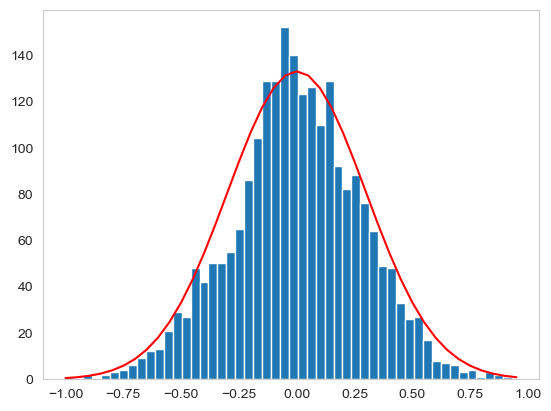

In [13]:
plt.hist(sp500processed, bins=50)
x_axis = np.arange(-1, 1, 0.05)
plt.plot(x_axis, norm.pdf(x_axis, 0, 0.3) * 100, color= 'r')
plt.grid(False)
plt.show()

In [14]:
class SP500Dataset(Dataset):
    def __init__(self, data, window):
        self.data = data
        self.window = window

    def __getitem__(self, index):
        x = np.expand_dims(self.data[index:index+self.window], -1)
        return torch.from_numpy(x).float()

    def __len__(self):
        return len(self.data) - self.window

#### GAN

In [15]:
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs, kernel_size, dilation):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_hidden, kernel_size, stride=1, dilation=dilation, padding='same')

        self.relu1 = nn.PReLU()
        self.conv2 = nn.Conv1d(n_hidden, n_outputs, kernel_size, stride=1, dilation=dilation, padding='same')
        self.relu2 = nn.PReLU()

        self.net = nn.Sequential(self.conv1, self.relu1, self.conv2, self.relu2)

        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None

        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return out + res

class TCN(nn.Module):
    def __init__(self, input_size, output_size, n_hidden=80):
        super(TCN, self).__init__()
        layers = []
        for i in range(7):
            num_inputs = input_size if i == 0 else n_hidden
            kernel_size = 2 if i > 0 else 1
            dilation = 2 * dilation if i > 1 else 1
            layers += [TemporalBlock(num_inputs, n_hidden, n_hidden, kernel_size, dilation)]
        self.conv = nn.Conv1d(n_hidden, output_size, 1)
        self.net = nn.Sequential(*layers)
        self.init_weights()

    def init_weights(self):
        self.conv.weight.data.normal_(0, 0.01)
    
    def forward(self, x):
        y1 = self.net(x.transpose(1, 2))
        return self.conv(y1).transpose(1, 2)

class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        self.net = TCN(input_size, output_size)

    def forward(self, x):
        return torch.tanh(self.net(x))

class Discriminator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Discriminator, self).__init__()
        self.net = TCN(input_size, output_size)

    def forward(self, x):
        return torch.sigmoid(self.net(x))

In [16]:
import numpy as np

patience = 15  
min_loss_diff = 0.001  
best_loss = np.inf  
trigger_times = 0  
clip_value = 0.01

lr = 0.0002
num_epochs = 100
nz = 3
batch_size = 30
seq_len = 127

netG = Generator(nz, 1).to(device)
netD = Discriminator(1, 1).to(device)
optD = optim.RMSprop(netD.parameters(), lr = lr)
optG = optim.RMSprop(netG.parameters(), lr = lr)

dataset = SP500Dataset(sp500processed, 127)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
t = tqdm(range(num_epochs))

for epoch in t:
    epoch_lossD = 0.0
    epoch_lossG = 0.0
    for i, data in enumerate(dataloader, 0):

        # Discriminator 학습
        netD.zero_grad()
        real = data.to(device)
        batch_size, seq_len = real.size(0), real.size(1)
        noise = torch.randn(batch_size, seq_len, nz, device=device)
        fake = netG(noise).detach()

        lossD = -torch.mean(netD(real)) + torch.mean(netD(fake))
        lossD.backward()
        optD.step()

        for p in netD.parameters():
            p.data.clamp_(-clip_value, clip_value)
  
        if i % 5 == 0:
            netG.zero_grad()
            lossG = -torch.mean(netD(netG(noise)))
            lossG.backward()
            optG.step()
        
        epoch_lossD += lossD.item()
        epoch_lossG += lossG.item()

    epoch_lossD /= len(dataloader)
    epoch_lossG /= len(dataloader)

    current_loss = epoch_lossD + epoch_lossG
    loss_diff = best_loss - current_loss
    if loss_diff > min_loss_diff:
        best_loss = current_loss
        trigger_times = 0
    else:
        trigger_times += 1

    # Early stopping 트리거 조건 만족 시 학습 종료
    if trigger_times >= patience:
        print("Early stopping at epoch %d" % epoch)
        break

    #Report metrics
    t.set_description('Loss_D: %.8f Loss_G: %.8f' % (epoch_lossD, epoch_lossG))
        
    # Checkpoint
    torch.save(netG, 'sp500_netG_epoch_%d.pth' % epoch)
    torch.save(netD, 'sp500_netD_epoch_%d.pth' % epoch)

  0%|          | 0/100 [00:00<?, ?it/s]/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_52h9q6gsr9/croot/pytorch-select_1707258249748/work/aten/src/ATen/native/Convolution.cpp:1041.)
  return F.conv1d(input, weight, bias, self.stride,
Loss_D: 0.00000036 Loss_G: -0.50683130:  30%|███       | 30/100 [01:51<04:21,  3.73s/it] 

Early stopping at epoch 30


In [17]:
len_data = len(sp500processed)

In [18]:
noise = torch.randn(
    1, len_data, 3, device = device 
)
fake = netG(noise).detach().cpu().reshape(len_data).numpy()

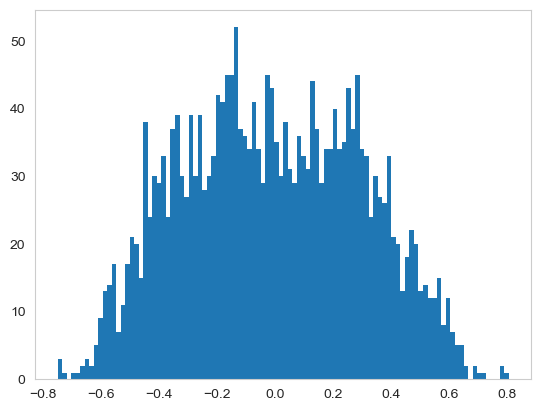

In [21]:
plt.hist(fake, bins = 100, edgecolor = 'none')
plt.grid(False)
plt.show()

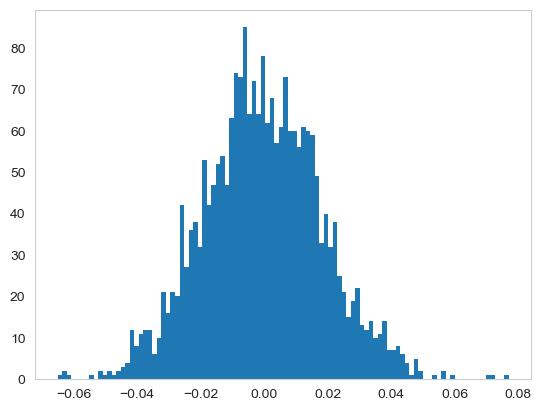

In [22]:
sp500fake = inverse(fake * sp500max, params = params)
plt.hist(sp500fake, bins=100, edgecolor = 'none')
plt.grid(False)
plt.show()

In [23]:
def generate_fakes(n=1, cumsum=True):
    fakes = []
    for i in range(n):
        noise = torch.randn(1, len_data, 3, device=device)
        fake = netG(noise).detach().cpu().reshape(len_data).numpy()
        sp500fake = inverse(fake * sp500max, params) + sp500log_mean
        fakes.append(sp500fake)
    if n > 1:
        if not cumsum:
            return pd.DataFrame(fakes).T
        fakes_df = pd.DataFrame(fakes).T.cumsum()
        return fakes_df
    elif not cumsum:
        return sp500fake
    return sp500fake.cumsum()

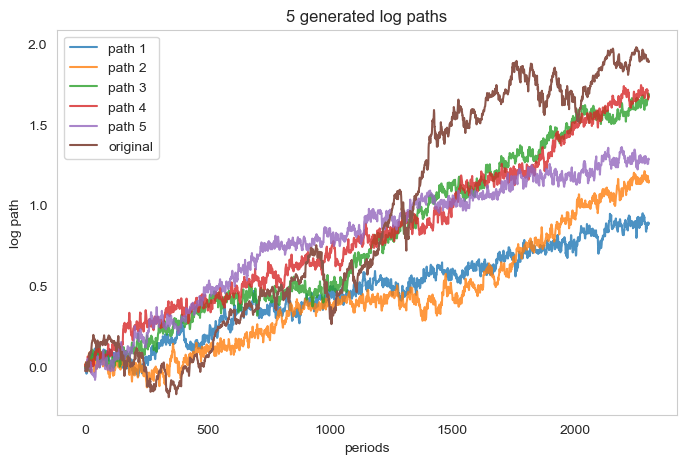

In [26]:
plt.figure(figsize = (8, 5))
plt.plot(generate_fakes(5), alpha = 0.8)
plt.plot(sp500log.cumsum().values, alpha = 1)
plt.legend([
    'path ' + str(i) for i in range(1, 6)
] + ['original'])
plt.grid(False)
plt.xlabel('periods')
plt.ylabel('log path')
plt.title('5 generated log paths')
plt.show()

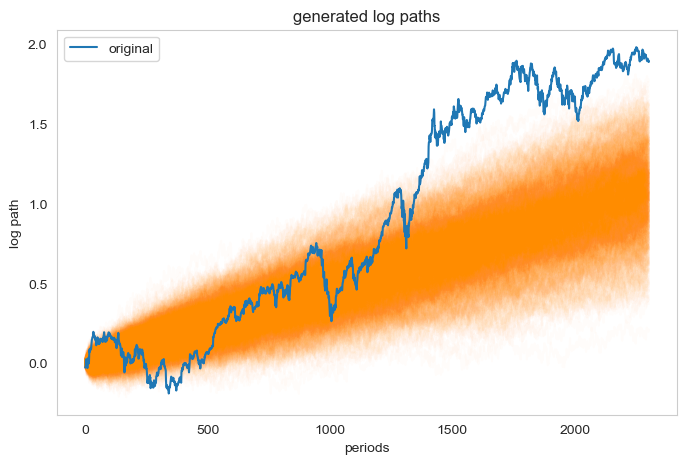

In [27]:
plt.figure(figsize = (8, 5))
plt.plot(generate_fakes(1000), alpha = 0.02, color = 'darkorange')
plt.plot(sp500log.cumsum().values, alpha = 1, label = 'original')
plt.grid(False)
plt.legend()
plt.xlabel('periods')
plt.ylabel('log path')
plt.title('generated log paths')
plt.show()

<Axes: xlabel='Date'>

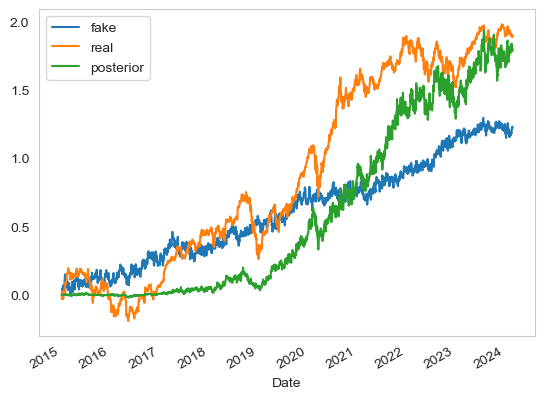

In [30]:
comp_df = pd.DataFrame(
    {'fake': generate_fakes(), 'real': sp500log.cumsum(), 'posterior' : generate_fakes() * sp500log.cumsum()} ,
    index = sp500log.index
)
comp_df.plot(grid = False)

### Sharpe Ratio 추정

In [35]:
simulation = pd.DataFrame(
    generate_fakes(1000).values,
    index = sp500log.index,
    columns = ['path_' + str(i) for i in range(1, 1001)]
)

In [51]:
from itertools import product
from tqdm import tqdm

def synthetic_simulation_gan(
        n_samples: int, # 각 iteration에서 생성할 데이터의 수
        nIter: int = 100,
        maxHP: int = 100, 
        rPT: np.ndarray = np.linspace(0.5, 10, 20), # 익절
        rSLm: np.ndarray = np.linspace(0.5, 10, 20), # 손절
        seed: int = 0
):
    print(f'Total {len(rPT) * len(rSLm)} iterations will be held.')
    output1 = []
    for comb_ in tqdm(product(rPT, rSLm)):
        output2 = []
        for iter_ in range(int(nIter)):
            # GAN 모델로부터 데이터 생성
            data = generate_fakes()
            hp, count = 0, 0
            for p in data:
                cP = p # GAN에서 생성된 데이터 사용
                hp += 1
                if cP > comb_[0] or cP < -comb_[1] or hp > maxHP:
                    output2.append(cP)
                    break
        mean, std = np.mean(output2), np.std(output2)
        output1.append((comb_[0], comb_[1], mean, std, mean / std))
    return output1

In [53]:
rPT = rSLm = np.linspace(0, 10, 21)
temp_sharpe = synthetic_simulation_gan(
    n_samples = 100, nIter = 1000, rPT = rPT, rSLm = rSLm
)

Total 441 iterations will be held.


441it [31:18,  4.26s/it]


In [54]:
from FinancialMachineLearning.backtest.backtest_synthetic_data import get_sharpe_grid
grid = get_sharpe_grid(temp_sharpe, rPT, rSLm)

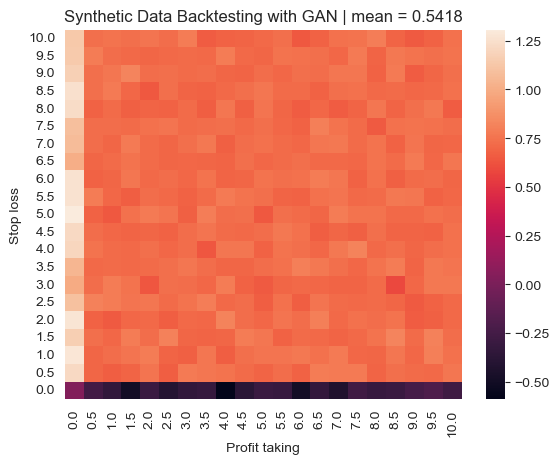

In [63]:
import seaborn as sns

sns.heatmap(grid)
plt.title(f"Synthetic Data Backtesting with GAN | mean = {simulation.mean(axis = 1).mean() :.4f}")
plt.xlabel("Profit taking")
plt.ylabel("Stop loss")
plt.grid(False)
plt.show()

In [67]:
gan_sr = (simulation.mean(axis = 0) - 0.035) / simulation.std(axis = 0)

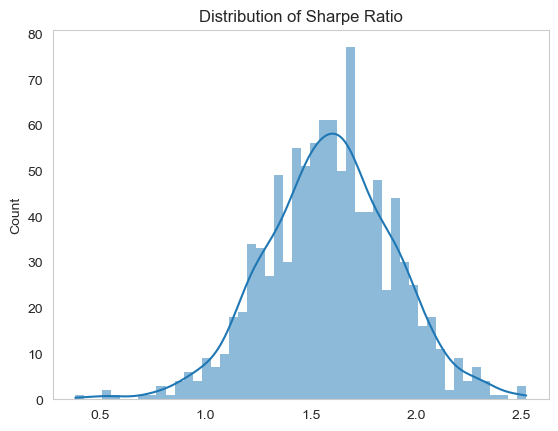

In [80]:
sns.histplot(
    gan_sr,
    bins = 50,
    edgecolor = 'none',
    kde = True
)
plt.grid(False)
plt.title('Distribution of Sharpe Ratio')
plt.show()

In [87]:
def synthetic_simulation_post(
        n_samples: int, # 각 iteration에서 생성할 데이터의 수
        nIter: int = 100,
        maxHP: int = 100, 
        rPT: np.ndarray = np.linspace(0.5, 10, 20), # 익절
        rSLm: np.ndarray = np.linspace(0.5, 10, 20), # 손절
        seed: int = 0
):
    print(f'Total {len(rPT) * len(rSLm)} iterations will be held.')
    output1 = []
    for comb_ in tqdm(product(rPT, rSLm)):
        output2 = []
        for iter_ in range(int(nIter)):
            data = generate_fakes() * sp500log
            hp, count = 0, 0
            for p in data:
                cP = p # GAN에서 생성된 데이터 사용
                hp += 1
                if cP > comb_[0] or cP < -comb_[1] or hp > maxHP:
                    output2.append(cP)
                    break
        mean, std = np.mean(output2), np.std(output2)
        output1.append((comb_[0], comb_[1], mean, std, mean / std))
    return output1

In [88]:
rPT = rSLm = np.linspace(0, 10, 21)
temp_sharpe_post = synthetic_simulation_post(
    n_samples = 100, nIter = 100, rPT = rPT, rSLm = rSLm
)

Total 441 iterations will be held.


441it [02:59,  2.46it/s]


In [90]:
grid_post = get_sharpe_grid(temp_sharpe_post, rPT, rSLm)

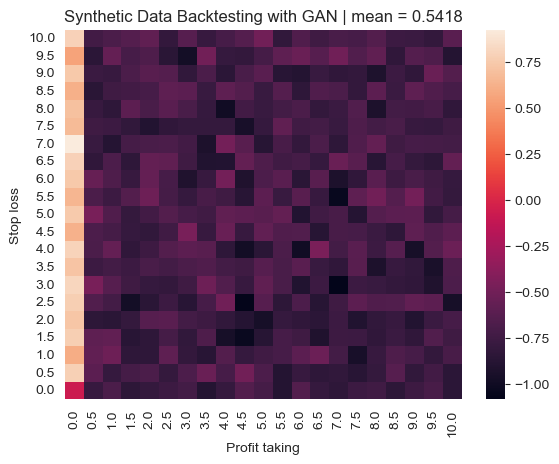

In [91]:
sns.heatmap(grid_post)
plt.title(f"Synthetic Data Backtesting with GAN | mean = {simulation.mean(axis = 1).mean() :.4f}")
plt.xlabel("Profit taking")
plt.ylabel("Stop loss")
plt.grid(False)
plt.show()